In [26]:
import pandas as pd
import numpy as np
import itertools, csv

1703 rows of qcd data
4605 rows of dihiggs data
Index(['hh_mass', 'h1_mass', 'h2_mass'], dtype='object') hh_mass


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe4320e7ef0>]],
      dtype=object)

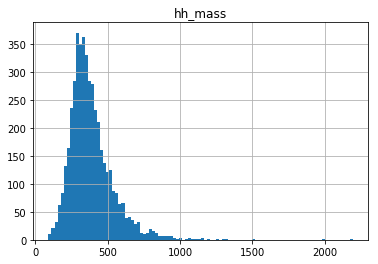

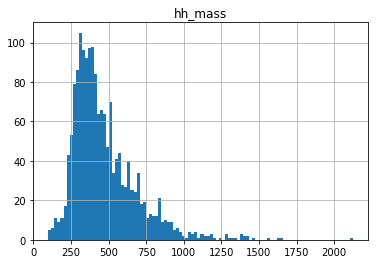

In [106]:
# *** 0. Import Dataset
qcd_raw = pd.read_csv('../higgsReconstruction/EventPlotting/qcd_outputDataForLearning.csv')
hh_raw = pd.read_csv('../higgsReconstruction/EventPlotting/dihiggs_outputDataForLearning.csv')

qcd_raw.head()
print(len(qcd_raw), "rows of qcd data")
hh_raw.head()
print(len(hh_raw), "rows of dihiggs data")
#print(hh_raw.columns)

variableNames = ['hh_mass', 'h1_mass', 'h2_mass']
#variableNames = ['hh_mass', 'h1_mass', 'h2_mass', 'deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)']

hh_reducedData  = hh_raw[variableNames]
qcd_reducedData = qcd_raw[variableNames]
print(hh_reducedData.columns, variableNames[0])
hh_reducedData.hist(column='hh_mass', bins=100)
qcd_reducedData.hist(column='hh_mass', bins=100)


In [123]:
def returnBestCutValue( _variable, _signal, _background, _method='S/B'):
    """find best cut according to user-specified significance metric"""
    
    _bestSignificance = -1
    _bestCutValue = -1
    _massWidth = 30.0 #GeV
    _nTotalSignal =len(_signal) 
    _nTotalBackground =len(_background) 
    
    _cuts = list(range(int(min(min(sortedBackground), min(sortedSignal))), int(max(max(sortedBackground), max(sortedSignal))), 5))
    
    for iCutValue in _cuts:
        if 'mass' in _variable:
            _nSignal = sum( (value > iCutValue and value < (iCutValue+_massWidth)) for value in _signal) 
            _nBackground = sum( (value > iCutValue and value < (iCutValue+_massWidth)) for value in _background)
        else:
            _nSignal = sum( value < iCutValue for value in _signal)
            _nBackground = sum( value < iCutValue for value in _background)

        # temporary fix since samples with different number of events
        _nSignal = _nSignal / _nTotalSignal
        _nBackground = _nBackground / _nTotalBackground
        
        # safety check to avoid division by 0
        if _nBackground == 0:
            continue
        
        #if _method == 'S/sqrt(S+B)':
        #    print(_nSignal, _nBackground, iCutValue, (_nSignal / np.sqrt(_nSignal + _nBackground)))
        
        if _method == 'S/B' and (_nSignal / _nBackground) > _bestSignificance:
            _bestSignificance = (_nSignal / _nBackground)
            _bestCutValue = iCutValue
        elif _method == 'S/sqrt(B)' and (_nSignal / np.sqrt(_nBackground)) > _bestSignificance:
            _bestSignificance = (_nSignal / np.sqrt(_nBackground))
            _bestCutValue = iCutValue
        elif _method == 'S/sqrt(S+B)' and (_nSignal / np.sqrt(_nSignal + _nBackground)) > _bestSignificance:
            _bestSignificance = (_nSignal / np.sqrt(_nSignal + _nBackground))
            _bestCutValue = iCutValue
        
    return _bestSignificance, _bestCutValue

def returnSignificanceOrderedCutDict( _method, _varNames, _signalDataFrame, _backgroundDataFrame):
    """function to return list of cuts ordered by descending significance"""
    
    _orderedVariableAndCutDict = {}
    _unprocessedVariables = _varNames
    
    while len(_unprocessedVariables)>0:
        _iBestCut = -1
        _iBestSignificance = -1
        _iBestVariable = ''
        
        for iVariable in _unprocessedVariables:
            _sortedSignal = np.sort(_signalDataFrame[iVariable].values)
            _sortedBackground = np.sort(_backgroundDataFrame[iVariable].values)
            #print(_sortedSignal)
            _tempSignificance, _tempCut = returnBestCutValue( iVariable, _sortedSignal, _sortedBackground, _method)
            #print ( iVariable, _tempSignificance, _tempCut )
                
            # most significant 1D variable so far in this iteration
            if _tempSignificance > _iBestSignificance:
                _iBestSignificance = _tempSignificance
                _iBestCut = _tempCut
                _iBestVariable = iVariable
        
        print('Iteration {0} chose variable {1} with significance {2} at cut {3}'.format(int(len(_varNames)-len(_unprocessedVariables)), _iBestVariable, _iBestSignificance, _iBestCut))
        _unprocessedVariables.remove(_iBestVariable)
        _orderedVariableAndCutDict[_iBestVariable] = [_iBestCut, _iBestSignificance]
        
    return _orderedVariableAndCutDict

In [124]:
for iColumn in range(0, len(hh_reducedData.columns) ):
    varName = variableNames[iColumn]
    sortedSignal = np.sort(hh_reducedData[varName].values)
    sortedBackground = np.sort(qcd_reducedData[varName].values)
    
    bestCut, significance = returnBestCutValue( varName, sortedSignal, sortedBackground, 'S/B')
    print ( varName, bestCut, significance )
    bestCut, significance = returnBestCutValue( varName, sortedSignal, sortedBackground, 'S/sqrt(B)')
    print ( varName, bestCut, significance )
    bestCut, significance = returnBestCutValue( varName, sortedSignal, sortedBackground, 'S/sqrt(S+B)')
    print ( varName, bestCut, significance )
    
print("=====================================")
    

hh_mass 3.581370364020801 190
hh_mass 0.41651627992212553 280
hh_mass 0.2636352469795921 280
h1_mass 3.2024441518238733 89
h1_mass 1.1896197668941786 89
h1_mass 0.5803061812511153 89
h2_mass 2.434935879497483 87
h2_mass 1.0065299443128946 87
h2_mass 0.5430844682055457 87


In [125]:
orderedCuts_SoverB = returnSignificanceOrderedCutDict( 'S/B', variableNames.copy(), hh_reducedData, qcd_reducedData)
print (orderedCuts_SoverB)
orderedCuts_SoverSqrtB = returnSignificanceOrderedCutDict( 'S/sqrt(B)', variableNames.copy(), hh_reducedData, qcd_reducedData)
print (orderedCuts_SoverSqrtB)

Iteration 0 chose variable hh_mass with significance 3.386730670324018 at cut 187
Iteration 0 chose variable h1_mass with significance 3.25115989236652 at cut 87
Iteration 0 chose variable h2_mass with significance 2.434935879497483 at cut 87
{'hh_mass': [187, 3.386730670324018], 'h1_mass': [87, 3.25115989236652], 'h2_mass': [87, 2.434935879497483]}
Iteration 0 chose variable h1_mass with significance 1.1947991987685098 at cut 87
Iteration 0 chose variable h2_mass with significance 1.0065299443128946 at cut 87
Iteration 0 chose variable hh_mass with significance 0.425209812783146 at cut 282
{'h1_mass': [87, 1.1947991987685098], 'h2_mass': [87, 1.0065299443128946], 'hh_mass': [282, 0.425209812783146]}


In [108]:
print(variableNames)

['hh_mass', 'h1_mass', 'h2_mass']


In [91]:
b=a.copy()

In [93]:
b.remove('b')

In [94]:
a

['a', 'b', 'c']

In [95]:
b

['a', 'c']